# Spot, motion detection and tracking of small, low-contrast objects

In [828]:
%reload_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import pandas as pd
from os import makedirs
from library.plot_helper import plot_pareto_front, get_video_files_dict, get_sample_count
from library.design_space import approximate_pareto
import numpy as np
import matplotlib.pyplot as plt

RENDER_LATEX = True
SAVE_FIG = True
DISABLE_NETWORK = False
# FORCE_CACHE = False

## Misc Figures

In [829]:
%reload_ext autoreload
%autoreload 2

from library.plot_helper import plot_precision_recall_curve

MAX_WIDTH=35
MAX_HEIGHT=35
ALLOW_OVERLAP=False

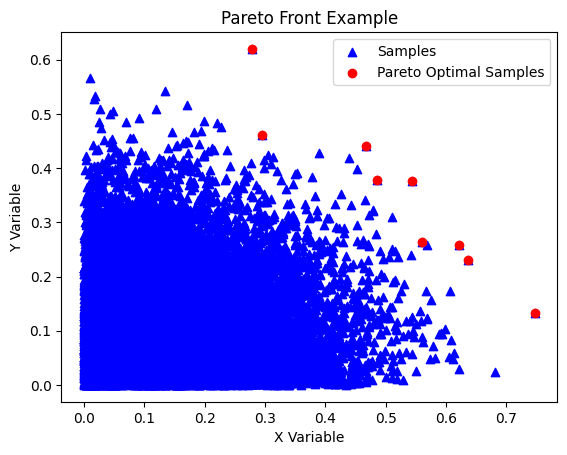

In [830]:
y = np.random.multivariate_normal([0, 0], [[0.03, 0], [0, 0.02]], 80000)
y = np.delete(y, y[:, 0] < 0, axis=0)
y = np.delete(y, y[:, 1] < 0, axis=0)

ypredict, ypredict_idx, _ = approximate_pareto(y)

plt.xlabel("X Variable")
plt.ylabel("Y Variable")
plt.title("Pareto Front Example")

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)

plt.scatter(y[:, 0], y[:, 1], marker='^', c="blue", label="Samples")
plt.scatter(ypredict[:, 0], ypredict[:, 1], color='red', label="Pareto Optimal Samples")

plt.legend()

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    plt.savefig("output/figures/fig_pareto_front_example.pdf")

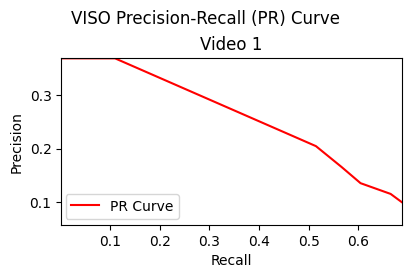

In [831]:
fig = plot_precision_recall_curve("VISO", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK)

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    plt.savefig("output/figures/fig_pr_example.pdf")

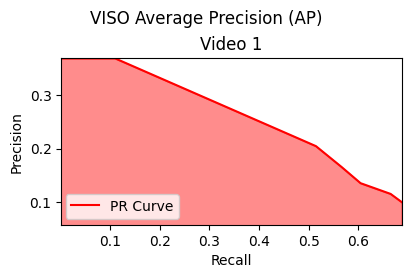

In [832]:
fig = plot_precision_recall_curve("VISO", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, fill=True, disable_network=DISABLE_NETWORK)

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    plt.savefig("output/figures/fig_ap_example.pdf")

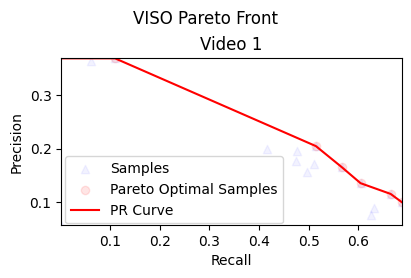

In [833]:
fig = plot_precision_recall_curve("VISO", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, display_pareto_front=True, disable_network=DISABLE_NETWORK)

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    plt.savefig("output/figures/fig_pareto_front_vs_pr_curve.pdf")

# Sherlock

In [834]:
%reload_ext autoreload
%autoreload 2

from library.plot_helper import get_sherlock_table, plot_sherlock_pareto_front, get_all_data

In [835]:
get_sherlock_table(disable_network=DISABLE_NETWORK)

,Video Name,Objective Function,Max Width,Max Height,Allow Overlap,Recall,Precision,F1,AP
0,Video 1,Problem Objective function 1,1024,1024,yes,0.9,0.51,0.65,0.51
1,Video 1,Problem Objective function 2,35,35,yes,0.82,0.64,0.72,0.59
2,Video 1,Final Objective Function,35,35,no,0.51,0.2,0.29,0.18


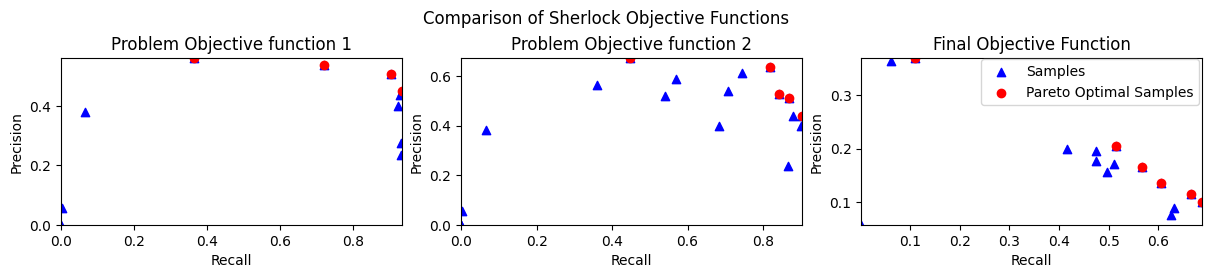

In [836]:
fig = plot_sherlock_pareto_front(disable_network=DISABLE_NETWORK)


if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    fig.savefig("./output/figures/fig_objective_functions_pareto.pdf", format="pdf")    

In [837]:
get_all_data(disable_network=DISABLE_NETWORK).to_csv("./output/all_data.csv")

## VISO Dataset

In [838]:
%reload_ext autoreload
%autoreload 2

from library.plot_helper import (
    get_viso_table_v,
    get_viso_table_vi,
    add_spot_row_viso_table_v,
    add_spot_row_viso_table_vi,
    add_average_column_viso_table_v,
    add_map_column_viso_table_vi,
    maximum_value_in_column,
    df2latex_table_v,
    df2latex_table_vi,
    plot_pareto_front_ref,
)

MAX_WIDTH=35
MAX_HEIGHT=35
ALLOW_OVERLAP=False

In [839]:
with pd.option_context('display.max_columns', None):
    display(
        HTML(
            add_average_column_viso_table_v(
                add_spot_row_viso_table_v(
                    get_viso_table_v(), max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK))
            .style.apply(maximum_value_in_column, axis=0).to_html().replace("0000", "")))

In [840]:
if RENDER_LATEX:
    df = add_average_column_viso_table_v(
            add_spot_row_viso_table_v(
                get_viso_table_v(), max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK))

    print(df2latex_table_v(df, 0))
    print(df2latex_table_v(df, 1))


\begin{tabular}{c c c c c c c c c c c c c c}
    \hline\\
    Method & \multicolumn{3}{c}{Video 1} & \multicolumn{3}{c}{Video 2} & \multicolumn{3}{c}{Video 3} & \multicolumn{3}{c}{Video 4}\\
    & Recall & Precision & F1 & Recall & Precision & F1 & Recall & Precision & F1 & Recall & Precision & F1\\
    \hline\\
    FD \cite{cao_two_2015} & 0.58 & 0.19 & 0.29 & 0.79 & 0.25 & 0.38 & 0.80 & 0.25 & 0.39 & 0.69 & 0.22 & 0.33\\
    ABM \cite{gutchess_background_2001} & 0.81 & 0.64 & 0.71 & 0.79 & 0.71 & 0.75 & 0.92 & 0.60 & 0.73 & \textcolor{red}{0.88} & 0.56 & 0.68\\
    MGBS \cite{hutchison_detection_2010} & 0.80 & 0.47 & 0.59 & 0.78 & 0.52 & 0.63 & 0.91 & 0.36 & 0.52 & 0.86 & 0.27 & 0.41\\
    GMM \cite{zivkovic_efficient_2006} & 0.37 & 0.63 & 0.47 & 0.49 & 0.53 & 0.51 & 0.45 & 0.53 & 0.49 & 0.64 & 0.36 & 0.46\\
    AGMM \cite{horng-horng_lin_regularized_2011} & 0.72 & 0.56 & 0.63 & 0.80 & 0.77 & 0.79 & \textcolor{blue}{0.93} & 0.65 & 0.76 & \textcolor{blue}{0.87} & 0.62 & 0.72\\
    VI

In [841]:
with pd.option_context('display.max_columns', None):
    display(
        HTML(
            add_map_column_viso_table_vi(
                add_spot_row_viso_table_vi(
                    get_viso_table_vi(), max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK))
            .style.apply(maximum_value_in_column, axis=0).to_html().replace("0000", "")))

,Method,Video 1,Video 2,Video 3,Video 4,Video 5,Video 6,Video 7,mAP
0,FD,0.26,0.55,0.51,0.47,0.44,0.55,0.28,0.44
1,ABM,0.59,0.70,0.76,0.67,0.65,0.63,0.01,0.57
2,MGBS,0.73,0.62,0.58,0.41,0.49,0.30,0.10,0.46
3,GMM,0.41,0.41,0.56,0.39,0.35,0.36,0.16,0.38
4,AGMM,0.64,0.71,0.75,0.71,0.61,0.60,0.47,0.64
5,VIBE,0.55,0.73,0.56,0.54,0.67,0.50,0.30,0.55
6,FPCP,0.54,0.45,0.42,0.28,0.27,0.35,0.20,0.36
7,GoDec,0.56,0.75,0.72,0.64,0.74,0.68,0.30,0.63
8,DECOLOR,0.42,0.73,0.81,0.56,0.75,0.72,0.52,0.64
9,FRMC,0.51,0.22,0.23,0.20,0.11,0.14,0.13,0.22


In [842]:
if RENDER_LATEX:
    print(df2latex_table_vi(add_map_column_viso_table_vi(
            add_spot_row_viso_table_vi(
                get_viso_table_vi(), max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK))))


\begin{tabular}{c c c c c c c c c}
    \hline \\
    Method & Video 1 & Video 2 & Video 3 & Video 4 & Video 5 & Video 6 & Video 7 & mAP\\
    \hline \\
    FD \cite{cao_two_2015} & 0.26 & 0.55 & 0.51 & 0.47 & 0.44 & 0.55 & 0.28 & 0.44\\
    ABM \cite{gutchess_background_2001} & 0.59 & 0.70 & 0.76 & 0.67 & 0.65 & 0.63 & 0.01 & 0.57\\
    MGBS \cite{hutchison_detection_2010} & 0.73 & 0.62 & 0.58 & 0.41 & 0.49 & 0.30 & 0.10 & 0.46\\
    GMM \cite{zivkovic_efficient_2006} & 0.41 & 0.41 & 0.56 & 0.39 & 0.35 & 0.36 & 0.16 & 0.38\\
    AGMM \cite{horng-horng_lin_regularized_2011} & 0.64 & 0.71 & 0.75 & 0.71 & 0.61 & 0.60 & 0.47 & 0.64\\
    VIBE \cite{barnich_vibe_2011} & 0.55 & 0.73 & 0.56 & 0.54 & 0.67 & 0.50 & 0.30 & 0.55\\
    FPCP \cite{rodriguez_fast_2013} & 0.54 & 0.45 & 0.42 & 0.28 & 0.27 & 0.35 & 0.20 & 0.36\\
    GoDec \cite{zhou_godec_nodate} & 0.56 & 0.75 & 0.72 & 0.64 & 0.74 & 0.68 & 0.30 & 0.63\\
    DECOLOR \cite{xiaowei_zhou_moving_2013} & 0.42 & 0.73 & \textcolor{blue}{0.81}

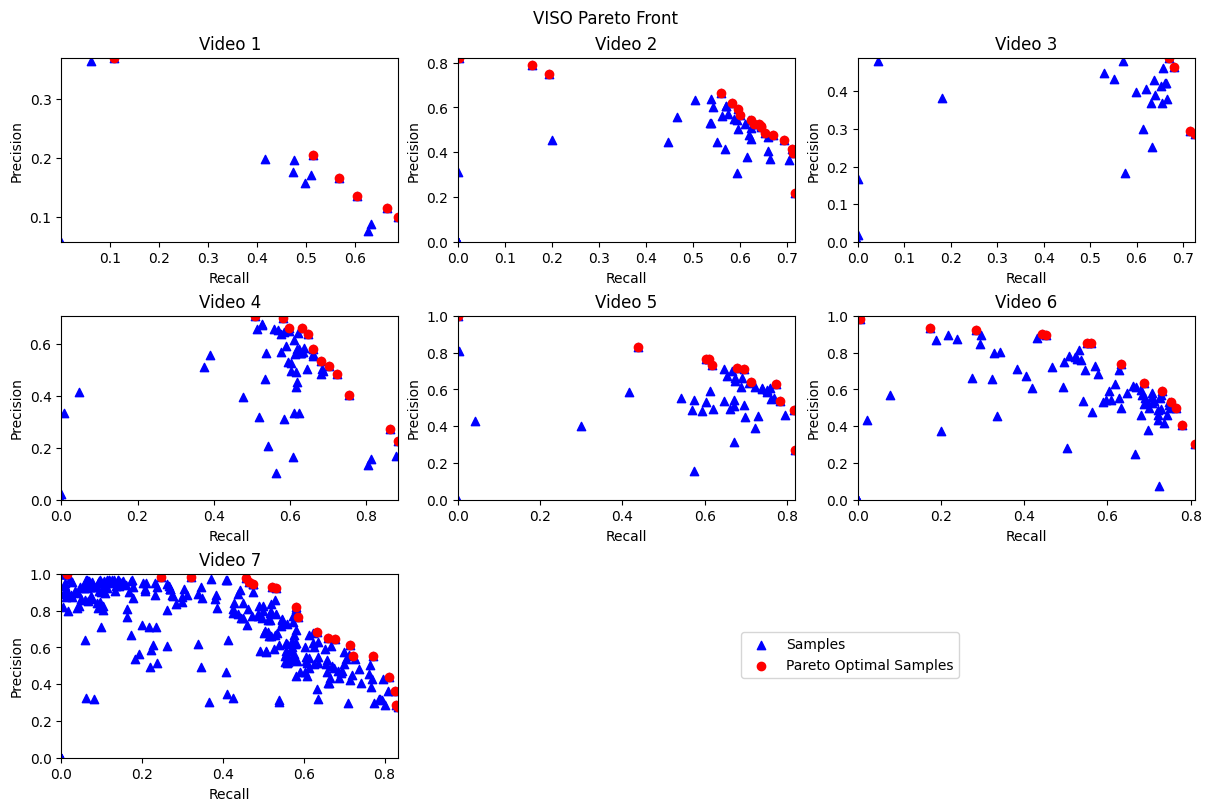

In [843]:
fig = plot_pareto_front("VISO", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK)

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    fig.savefig("./output/figures/fig_viso_pareto.pdf", format="pdf")

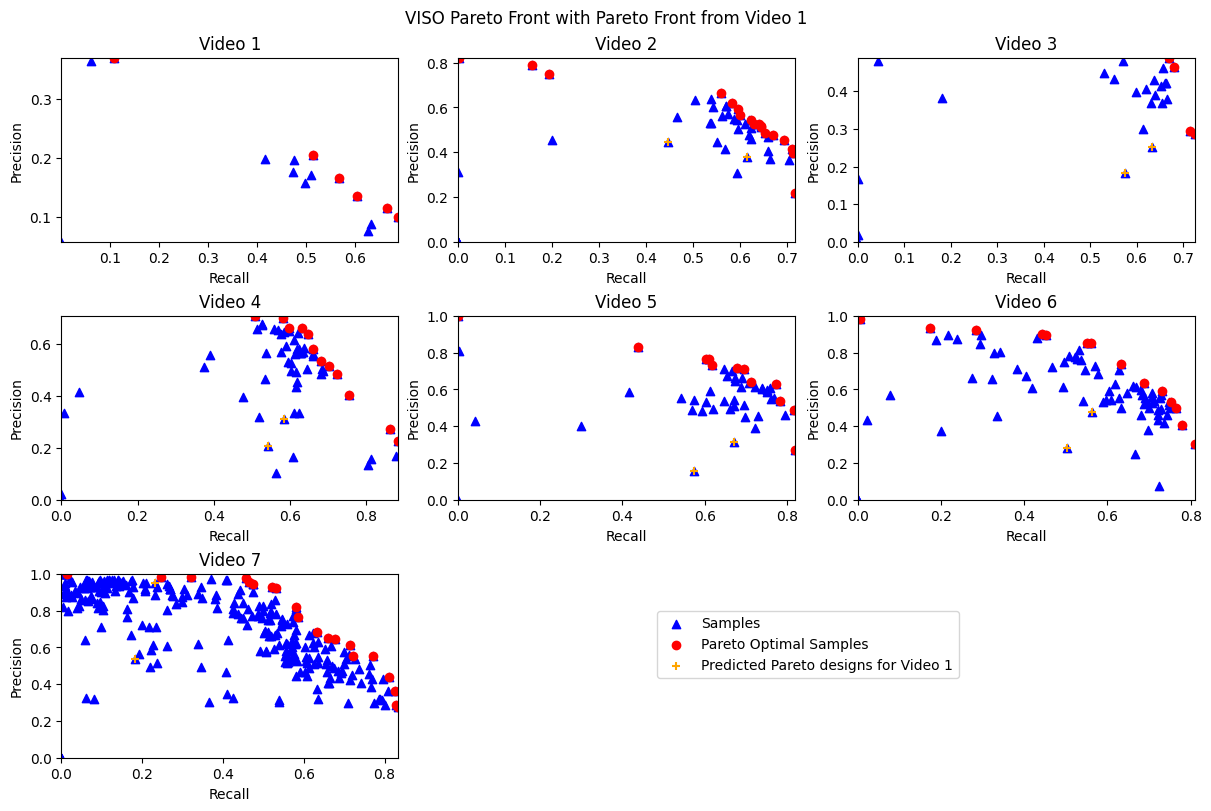

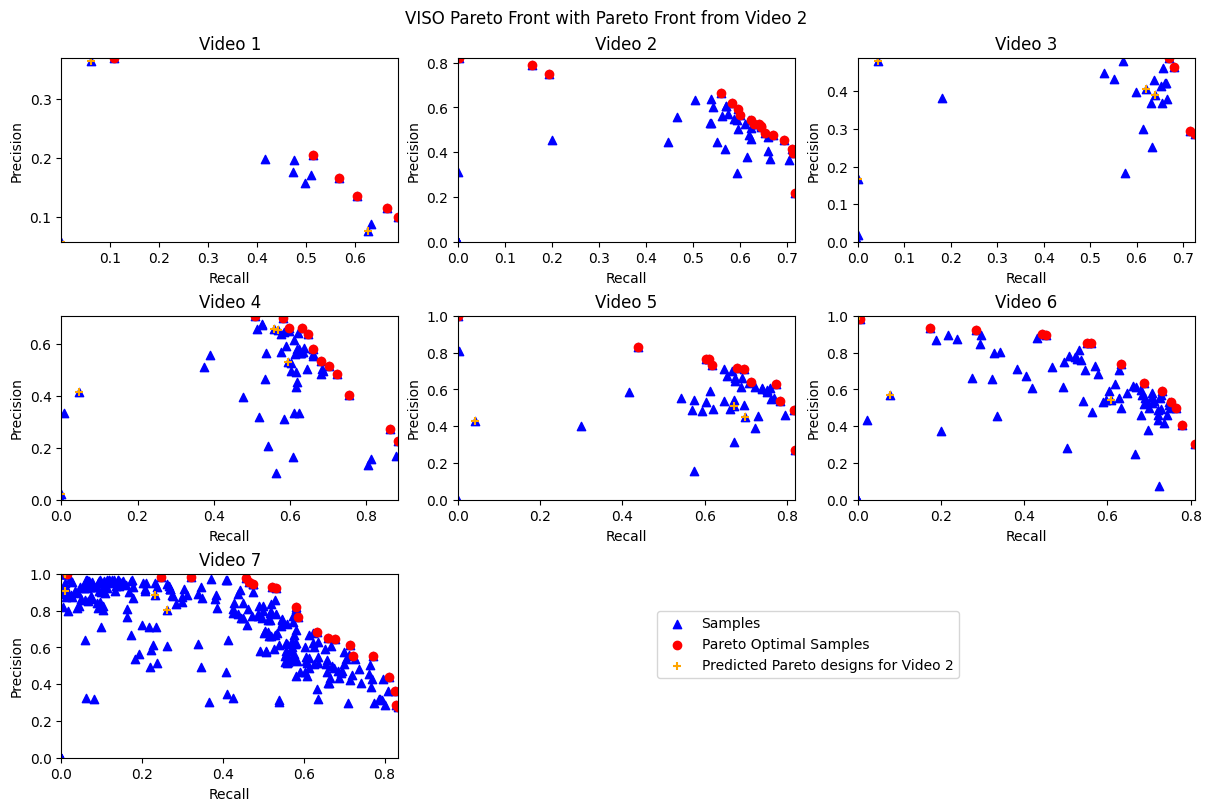

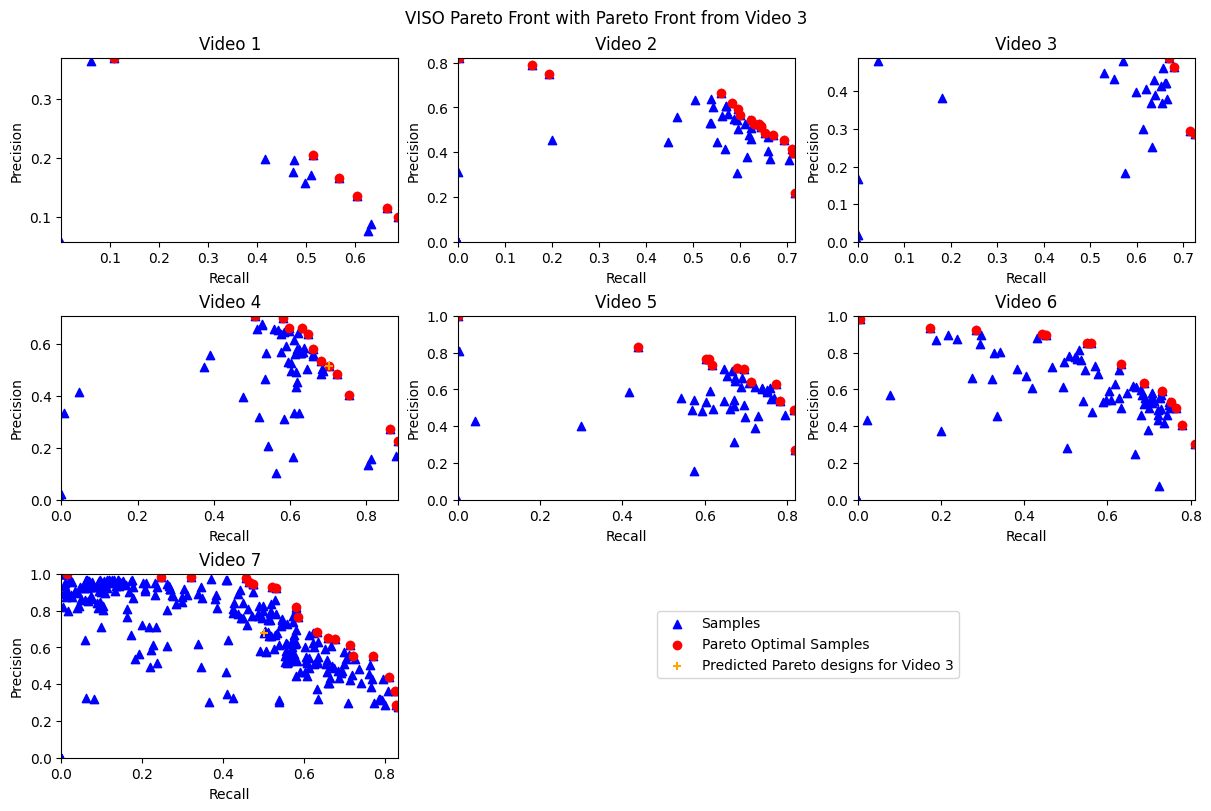

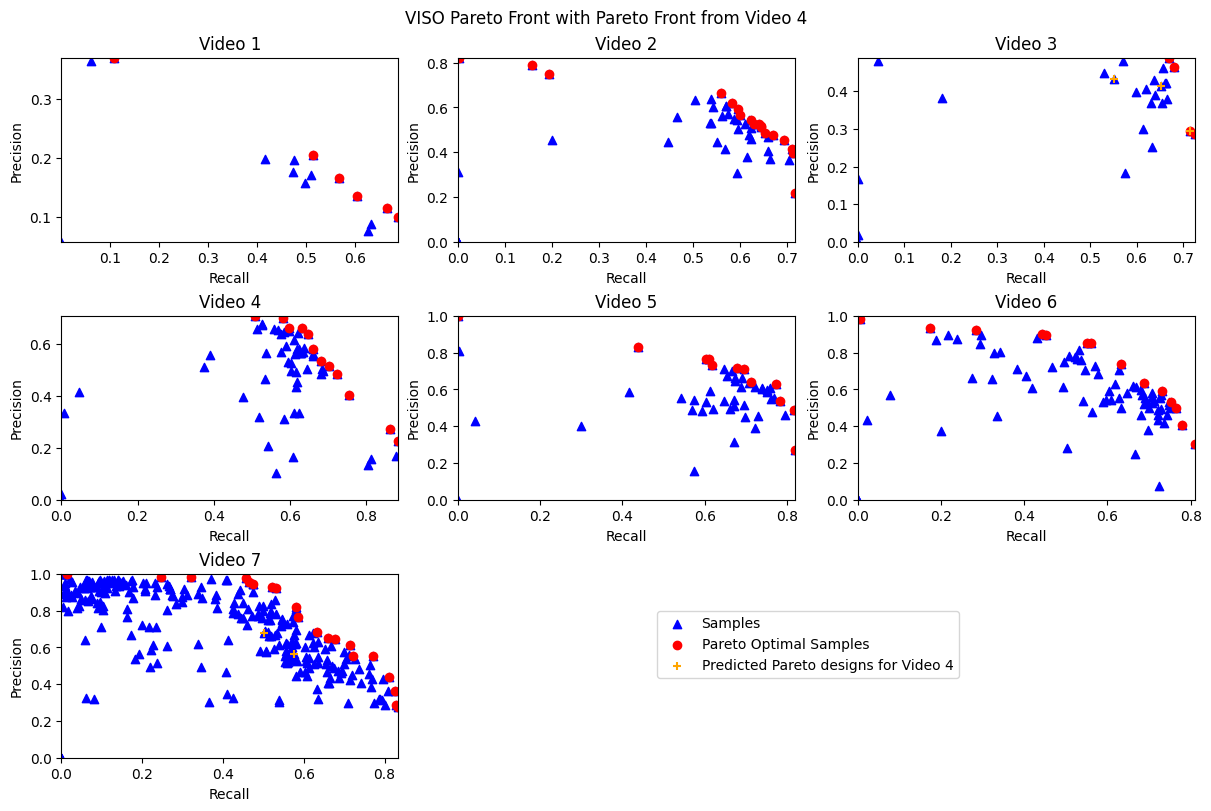

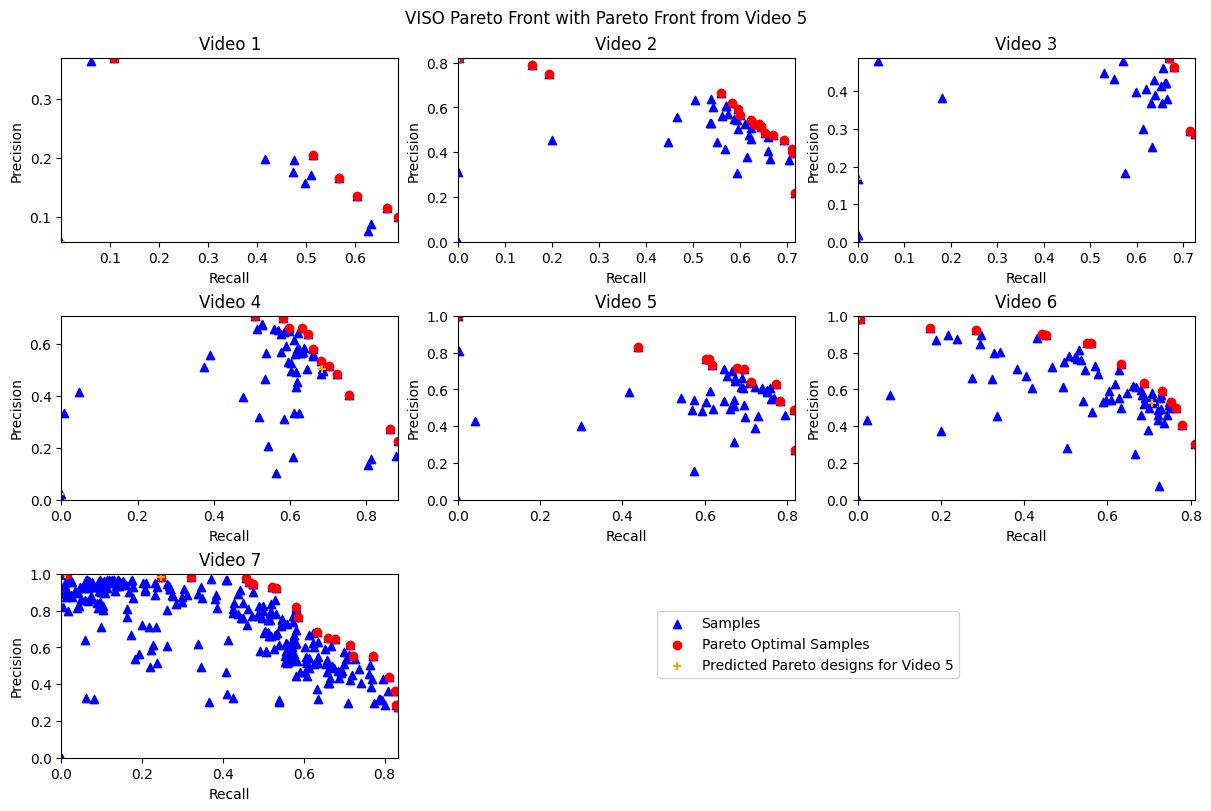

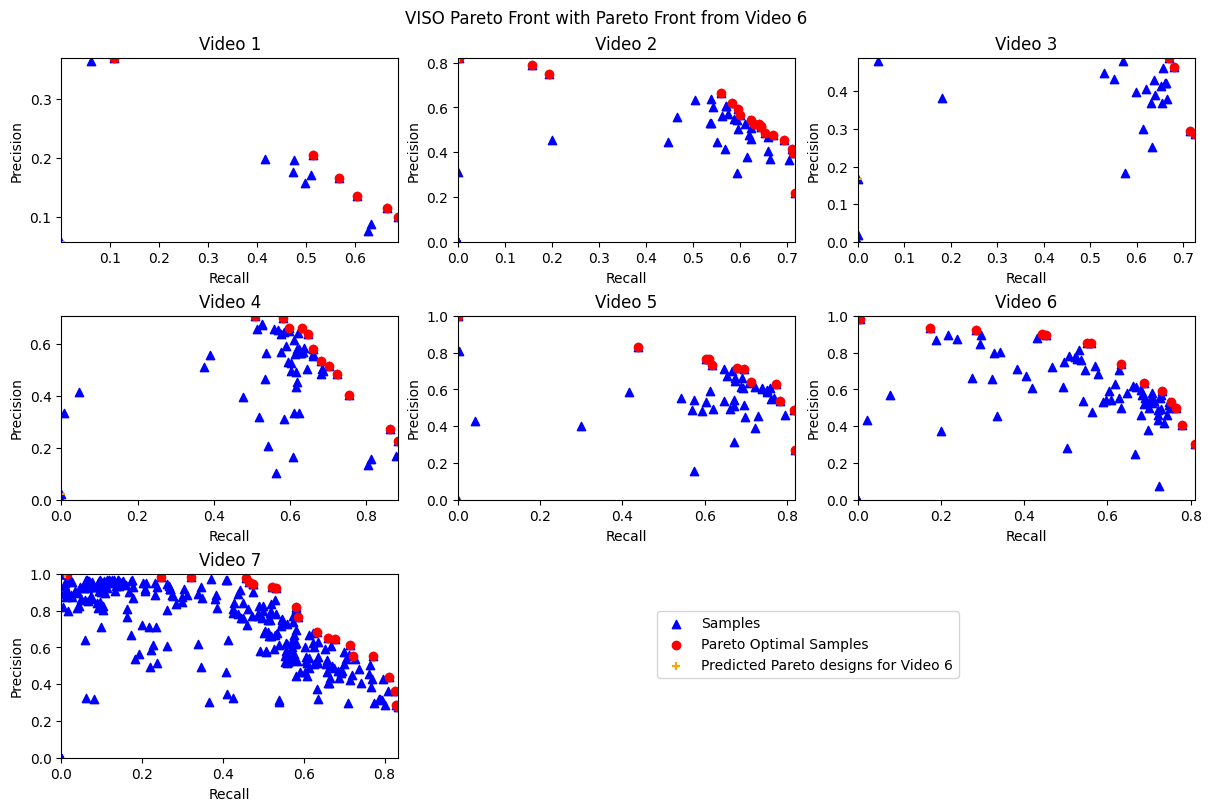

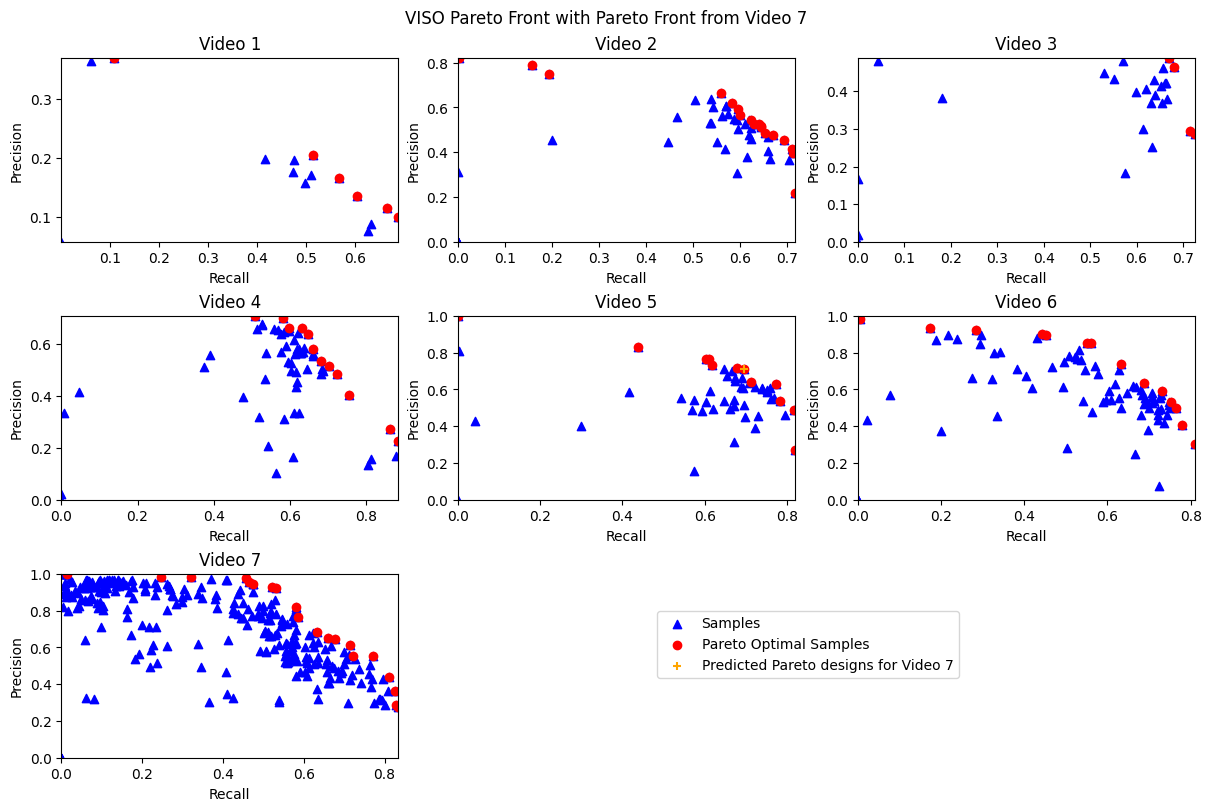

In [844]:
figs = plot_pareto_front_ref("VISO", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK)

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    dataset_dict = get_video_files_dict("VISO")
    
    for video_file, fig in figs:
        video_name = [k for k, v in dataset_dict.items() if v == video_file][0]
        fig.savefig(f"./output/figures/fig_viso_{video_name.lower().replace(' ', '_')}_pareto.pdf", format="pdf")

In [845]:
get_sample_count("VISO", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK)

,Video Name,Sampled Count,Sampled Percent,Pareto Optimal Count
0,Video 1,15,0.08%,6
1,Video 2,52,0.27%,18
2,Video 3,26,0.14%,4
3,Video 4,62,0.32%,12
4,Video 5,52,0.27%,12
5,Video 6,85,0.44%,15
6,Video 7,303,1.58%,20


## Baboon Dataset

In [846]:
from library.plot_helper import get_dataset_results

MAX_WIDTH=(55, 70)
MAX_HEIGHT=(55, 70)
ALLOW_OVERLAP=False

In [847]:
get_dataset_results("Baboons", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK)

,Video Name,Recall,Precision,F1,AP
0,Video 1,0.50,0.59,0.54,0.41
1,Video 2,0.39,0.20,0.26,0.11


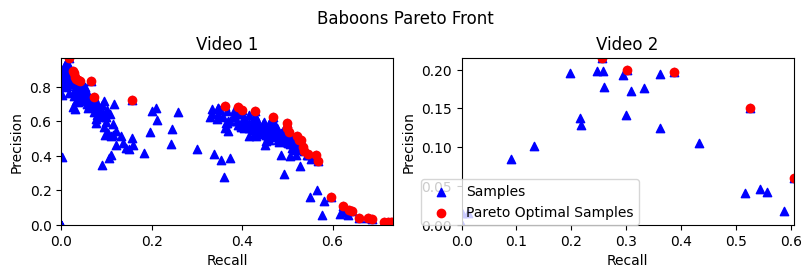

In [848]:
fig = plot_pareto_front("Baboons", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK)

if SAVE_FIG:
    makedirs("./output/figures", exist_ok=True)
    fig.savefig("./output/figures/fig_baboons_pareto.pdf", format="pdf")    

In [849]:
get_sample_count("Baboons", max_width=MAX_WIDTH, max_height=MAX_HEIGHT, allow_overlap=ALLOW_OVERLAP, disable_network=DISABLE_NETWORK)

,Video Name,Sampled Count,Sampled Percent,Pareto Optimal Count
0,Video 1,322,1.68%,37
1,Video 2,28,0.15%,5
